In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as mariadb

from langchain_teddynote.models import get_model_name, LLMs
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents import create_sql_agent
from langchain.tools import StructuredTool
from langchain_experimental.tools import PythonAstREPLTool
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.prompts import load_prompt
from langchain_core.prompts import ChatPromptTemplate

from prompts import Prompt
from utils import *

from typing import List

%load_ext autoreload
%autoreload 2

/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/langchain_experimental/tools/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_experimental.tools.python.tool import PythonAstREPLTool, PythonREPLTool
/Users/iminhyeong/opt/anaconda3/envs/llm_venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:777: UserWarning: Mixing V1 models and V2 models (or constructs, like `TypeAdapter`) is not supported. Please upgrade `PythonREPL` to V2.
  war

In [3]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

# LangSmith 추적을 설정합니다. https://smith.langchain.com
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("KWATER-GPT")


LangSmith 추적을 시작합니다.
[프로젝트명]
KWATER-GPT


In [4]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

In [7]:
MODEL_NAME = get_model_name(LLMs.GPT4o)
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)

# DB Research Team

In [8]:
from agent_config import AgentConfig
from data import DBManager

conf = AgentConfig(
    location_code="A",
    plant_code="SN",
    algorithm_code="C"
)
dbm = DBManager(conf)
db = dbm.get_db_connection()


## 1. 테이블 선택

In [9]:
from utils import extract_tables, json_parse, convert_value, process_ai_rt
from types import SimpleNamespace

def select_table(state: State):
    prompt = Prompt()
    table_selection_prompt = prompt.table_selection_prompt()

    select_table_chain = table_selection_prompt | llm | StrOutputParser()

    table_list = select_table_chain.invoke(state["messages"])
    table_list = extract_tables(table_list)

    return {"messages": state["messages"],
            "table_list": table_list,
            }


def generate_query(state: State):
    def process_schema_for_prompt(table_name, schema_text):
        """테이블별로 스키마 정보 처리"""
        if table_name == "TB_AI_C_RT":
            # JSON이 많은 테이블은 샘플 데이터 제외
            return schema_text.split("/*")[0].strip()
        else:
            # 다른 테이블은 샘플 데이터 포함
            return schema_text
            
    TABLE_SCHEMAS = {
            table: db.get_table_info([table]) for table in state["table_list"]
        }
    schema_info = ""
    for table, schema in TABLE_SCHEMAS.items():
        schema_info += f"\n## {table} Table:\n{process_schema_for_prompt(table, schema)}\n"
    
    prompt = Prompt()
    sql_generation_prompt = prompt.sql_generation_prompt()
    sql_generation_chain = sql_generation_prompt | llm | StrOutputParser()

    sql_query_dict = sql_generation_chain.invoke({"question": state["messages"],
                                                  "schema_info": schema_info})
    
    sql_query_dict = json_parse(sql_query_dict)

    return {"messages": state["messages"],
            "table_list": state["table_list"],
            "sql_query_dict": sql_query_dict}



def load_data_from_db(state: State):
    sql_query_dict = state["sql_query_dict"]
    df_dict = {}
    for table, query in sql_query_dict.items():
        df = dbm.select_from_table(query)
        # display(df)
        df_dict[table] = df

    return {"messages": state["messages"],
            "table_list": state["table_list"],
            "sql_query_dict": sql_query_dict,
            "df_dict": df_dict}

def preprocess_data(state: State):
    dfs = SimpleNamespace(**state["df_dict"])
    
    if hasattr(dfs, "TB_C_RT"):
        dfs.TB_C_RT = dfs.TB_C_RT.applymap(convert_value)
    
    if hasattr(dfs, "TB_AI_C_CTR"):
        dfs.TB_AI_C_CTR = dfs.TB_AI_C_CTR.applymap(convert_value)

    if hasattr(dfs, "TB_AI_C_RT"):
        ai_rt = dfs.TB_AI_C_RT.copy()
        ai_rt = ai_rt.set_index("UPD_TI")
        multi_columns = pd.MultiIndex(levels=[[], [], [], [], []], codes=[[], [], [], [], []], names=['ITM', 'STG', 'SER', 'LOC', 'STP'])
        df = pd.DataFrame(columns = multi_columns, index = ai_rt.index)
    
        for col in ai_rt.columns:
            for idx in ai_rt.index:
                for path, val in process_ai_rt(ai_rt.at[idx, col]):
                    df.at[idx, path] = val
        dfs.TB_AI_C_RT = df
        
    return {"messages": state["messages"],
            "table_list": state["table_list"],
            "sql_query_dict": state["sql_query_dict"],
            "df_dict": dfs}

def generate_response(state: State):  

    python_repl = PythonAstREPLTool(
            globals={"pd": pd, "plt": plt, "np": np, "sns": sns, "df": df.copy()},  # 필요한 모듈들을 globals에 추가
            locals=None
            # locals={"df": dataframe}  # 데이터프레임을 locals에 추가
        )
    
    agent = create_pandas_dataframe_agent(
        llm,
        df,
        verbose=True,
        tools=[python_repl],
        return_intermediate_steps=True
    )
    pass



In [10]:
# inputs = {"messages": [("human", "최근 AI 약품 주입률의 추이를 보여줘")]}
inputs = {"messages": "3월 10일부터 3월 11일까지 AI 약품 기본 주입률을 알려줘"}

result = select_table(inputs)
result = generate_query(result)
result = load_data_from_db(result)
result = preprocess_data(result)


In [11]:
result

{'messages': '3월 10일부터 3월 11일까지 AI 약품 기본 주입률을 알려줘',
 'table_list': ['TB_AI_C_RT', 'TB_TAG_MNG'],
 'sql_query_dict': {},
 'df_dict': namespace()}

<Axes: xlabel='UPD_TI'>

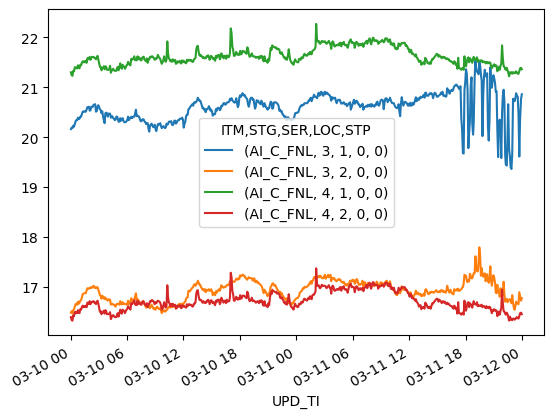

In [33]:

df.loc[:, (df.columns.get_level_values("ITM") == 'AI_C_FNL')].plot()

In [16]:
result_data = preprocess_data(result)

In [18]:
result_data.TB_AI_C_RT

ITM                 AI_OPR                 B_TB  B_PH   B_AL  B_TE    B_CU  \
STG                      3         4          0     0      0     0       0   
SER                      1    2    1    2     0     0      0     0       0   
LOC                      0    0    0    0     0     0      0     0       0   
STP                      0    0    0    0     0     0      0     0       0   
UPD_TI                                                                       
2025-03-11 23:59:00    2.0  0.0  2.0  0.0  3.59  8.19  62.98  7.27  237.39   
2025-03-11 23:54:00    2.0  0.0  2.0  0.0  3.59  8.18  64.32  7.27  237.02   
2025-03-11 23:48:00    2.0  0.0  2.0  0.0  3.62  8.18  74.58  7.29  236.15   
2025-03-11 23:43:00    2.0  0.0  2.0  0.0  3.58  8.18  97.31  7.25  236.01   
2025-03-11 23:38:00    2.0  0.0  2.0  0.0  3.51  8.18  69.46  7.26  235.14   
...                    ...  ...  ...  ...   ...   ...    ...   ...     ...   
2025-03-10 00:22:00    2.0  0.0  2.0  0.0  3.49  8.41  72.18  6.88  251.82   
2025-03-10 00:17:00    2.0  0.0  2.0  0.0  3.53  8.41  71.35  6.88  251.97   
2025-03-10 00:12:00    2.0  0.0  2.0  0.0  3.46  8.41  71.24  6.90  252.23   
2025-03-10 00:07:00    2.0  0.0  2.0  0.0  3.48  8.41  71.76  6.87  252.30   
2025-03-10 00:02:00    2.0  0.0  2.0  0.0  3.49  8.41  71.72  6.86  252.27   

ITM                     0  ... AI_C_UCL        AI_C_LCL                       \
STG                     0  ...        4               3             4          
SER                     0  ...        1      2        1      2      1      2   
LOC                     0  ...        0      0        0      0      0      0   
STP                     0  ...        0      0        0      0      0      0   
UPD_TI                     ...                                                 
2025-03-11 23:59:00  None  ...    21.05  20.60    12.23  12.43  12.02  12.39   
2025-03-11 23:54:00  None  ...    21.05  20.60    12.23  12.43  12.02  12.39   
2025-03-11 23:48:00  None  ...    21.09  20.64    12.25  12.45  12.03  12.41   
2025-03-11 23:43:00  None  ...    21.03  20.59    12.22  12.43  12.01  12.38   
2025-03-11 23:38:00  None  ...    20.94  20.50    12.18  12.39  11.96  12.33   
...                   ...  ...      ...    ...      ...    ...    ...    ...   
2025-03-10 00:22:00  None  ...    20.91  20.47    12.17  12.38  11.95  12.32   
2025-03-10 00:17:00  None  ...    20.96  20.51    12.19  12.39  11.97  12.34   
2025-03-10 00:12:00  None  ...    20.86  20.42    12.14  12.35  11.92  12.29   
2025-03-10 00:07:00  None  ...    20.90  20.45    12.16  12.37  11.94  12.31   
2025-03-10 00:02:00  None  ...    20.91  20.47    12.17  12.38  11.95  12.32   

ITM                 AI_E_TB_B_TRG                    
STG                             3           4        
SER                             1     2     1     2  
LOC                             0     0     0     0  
STP                             0     0     0     0  
UPD_TI                                               
2025-03-11 23:59:00          0.34  0.34  0.37  0.37  
2025-03-11 23:54:00          0.34  0.34  0.37  0.37  
2025-03-11 23:48:00          0.34  0.34  0.37  0.37  
2025-03-11 23:43:00          0.34  0.34  0.37  0.37  
2025-03-11 23:38:00          0.34  0.34  0.37  0.37  
...                           ...   ...   ...   ...  
2025-03-10 00:22:00          0.34  0.34  0.37  0.37  
2025-03-10 00:17:00          0.34  0.34  0.37  0.37  
2025-03-10 00:12:00          0.34  0.34  0.37  0.37  
2025-03-10 00:07:00          0.34  0.34  0.37  0.37  
2025-03-10 00:02:00          0.34  0.34  0.37  0.37  

[576 rows x 78 columns]

In [122]:
result.TB_AI_C_RT.columns

MultiIndex([(0, 0, 0, 0, 0)],
           names=['ITM', 'STG', 'SER', 'LOC', 'STP'])

In [75]:
result.TB_AI_C_RT.AI_OPR[0]

'{"AI_OPR": {"STG_3": {"SER_1": "2;NONE", "SER_2": "0;NONE"}, "STG_4": {"SER_1": "2;NONE", "SER_2": "0;NONE"}}}'

In [14]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langgraph.graph import END, START, StateGraph

# 상태 정의(add_messages 리듀서 사용)
class State(TypedDict):
    messages: Annotated[list, add_messages]
    table_list: list
    sql_query_dict: dict
    df_dict: dict


builder = StateGraph(State)

builder.add_node("select_table", select_table)
builder.add_node("generate_query", generate_query)
builder.add_node("load_data_from_db", load_data_from_db)
builder.add_node("preprocess_data", preprocess_data)
builder.add_node("generate_response", generate_response)

builder.add_edge(START, "select_table")
builder.add_edge("select_table", "generate_query")
builder.add_edge("generate_query", "load_data_from_db")
builder.add_edge("load_data_from_db", "preprocess_data")
builder.add_edge("preprocess_data", "generate_response")
builder.add_edge("generate_response", END)


graph = builder.compile()

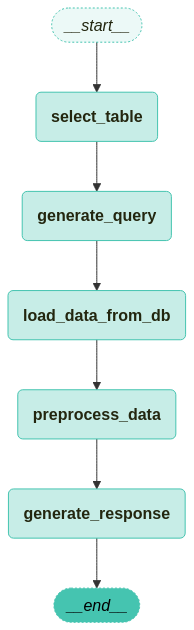

In [15]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)